In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pydrake.all import MathematicalProgram, Solve, SolverOptions, CommonSolverOption

In [3]:
from pydrake.all import MathematicalProgram, CommonSolverOption, SolverOptions, Solve
from ellipse_utils import (switch_ellipse_description, 
                           arrange_homogeneous_ellipse_matrix_to_vector, 
                           build_quadratic_features,
                           get_hyperellipsoid_from_homogeneous_matrix,
                           plot_ellipse_homogenous_rep) 

# def add_positive_diagonal_dominance_constraints(prog, symmvar, min_diag = 1e-3):
#     n = symmvar.shape[0]
#     t = prog.NewContinuousVariables(n,n)
#     index = 0
#     for i in range(n):
#         for j in range(n):
#             prog.AddLinearConstraint(symmvar[i,j]<= t[i,j])
#             prog.AddLinearConstraint(symmvar[i,j]>= -t[i,j])
#             index+=1

#     for i in range(n):
#         #prog.AddLinearConstraint(symmvar[i,i]>=min_diag)
#         prog.AddLinearConstraint(symmvar[i,i]>=np.sum(t[i,:])- t[i,i]+min_diag)
#         #prog.AddLinearConstraint(symmvar[i,i]>=min_diag)
#         # for j in range(i+1, n):
#         #     prog.AddLinearConstraint(symmvar[i,i]>=symmvar[i,j])
#         #     prog.AddLinearConstraint(-symmvar[i,i]<=symmvar[i,j])

def compute_outer_LJ_sphere(pts):
    dim = pts[0].shape[0]
    upper_triangular_indeces = []
    for i in range(dim-1):
        for j in range(i+1, dim):
            upper_triangular_indeces.append([i,j])

    upper_triangular_indeces = np.array(upper_triangular_indeces)
    prog = MathematicalProgram()
    inv_radius = prog.NewContinuousVariables(1, 'rad')
    A = inv_radius*np.eye(dim)
    b = prog.NewContinuousVariables(dim, 'b')
    prog.AddMaximizeLogDeterminantCost(A)
    for idx, pt in enumerate(pts):
        pt = pt.reshape(dim,1)
        S = prog.NewSymmetricContinuousVariables(dim+1, 'S')
        prog.AddPositiveSemidefiniteConstraint(S)
        prog.AddLinearEqualityConstraint(S[0,0] == 0.9)
        v = (A@pt + b.reshape(dim,1)).T
        c = (S[1:,1:]-np.eye(dim)).reshape(-1)
        for idx in range(dim):
            prog.AddLinearEqualityConstraint(S[0,1 + idx]-v[0,idx], 0 )
        for ci in c:
            prog.AddLinearEqualityConstraint(ci, 0 )

    prog.AddPositiveSemidefiniteConstraint(A) # eps * identity

    # for aij in A[upper_triangular_indeces[:,0], upper_triangular_indeces[:,1]]:
    #     prog.AddLinearConstraint(aij == 0)
    prog.AddPositiveSemidefiniteConstraint(10000*np.eye(dim)-A)

    sol = Solve(prog)
    if sol.is_success():
        HE, _, _ =switch_ellipse_description(sol.GetSolution(inv_radius)*np.eye(dim), sol.GetSolution(b))
    return HE


def max_clique(adj_mat):
    n = adj_mat.shape[0]
    prog = MathematicalProgram()
    v = prog.NewBinaryVariables(n)
    prog.AddLinearCost(-np.sum(v))
    for i in range(0,n):
        for j in range(i+1,n):
            if adj_mat[i,j] == 0:
                prog.AddLinearConstraint(v[i] + v[j] <= 1)

    solver_options = SolverOptions()
    solver_options.SetOption(CommonSolverOption.kPrintToConsole, 1)

    result = Solve(prog, solver_options=solver_options)
    print(result.is_success())
    return np.where(result.GetSolution(v)==1)[0], None, None

def max_clique_w_cvx_hull_constraint(adj_mat, graph_vertices):
    assert adj_mat.shape[0] == len(graph_vertices)
    #assert graph_vertices[0, :].shape[0] == points_to_exclude.shape[1]
    
    dim = graph_vertices.shape[1]
    #compute radius of circumscribed sphere of all points to get soft margin size
    HS = compute_outer_LJ_sphere(graph_vertices)
    radius = 1/(HS.A()[0,0]+1e-6)
    n = adj_mat.shape[0]
    
    prog = MathematicalProgram()
    v = prog.NewBinaryVariables(n)
    prog.AddLinearCost(-np.sum(v))
    
    #hyperplanes
    lambdas = prog.NewContinuousVariables(n, dim+1)
    #slack variables for soft margins
    gammas = prog.NewContinuousVariables(n, n)

    Points_mat = np.concatenate((graph_vertices,np.ones((n,1))), axis =1)
    #Exclusion_points_mat =  np.concatenate((points_to_exclude,np.ones((num_points_to_exclude,1))), axis =1)

    for i in range(0,n):
        for j in range(i+1,n):
            if adj_mat[i,j] == 0:
                prog.AddLinearConstraint(v[i] + v[j] <= 1)

    for i in range(n):
        constraint1 = -Points_mat@lambdas[i,:]+2*radius*gammas[i,:]
        constraint2 = Points_mat[i,:]@lambdas[i,:]  #+ np.sum(gammas)
        for k in range(n):
            prog.AddLinearConstraint(constraint1[k] >=0)

        prog.AddLinearConstraint(constraint2>=1-v[i]) #

    for i in range(n):
        gammas_point_i = gammas[i, :]    
        for vi, gi in zip(v, gammas_point_i):
            prog.AddLinearConstraint(gi >= (vi-1))

        for vi,gi in zip(v, gammas_point_i):
            prog.AddLinearConstraint((1-vi)>= gi )


    solver_options = SolverOptions()
    solver_options.SetOption(CommonSolverOption.kPrintToConsole, 1)

    result = Solve(prog, solver_options=solver_options)
    print(result.is_success())
    return np.where(result.GetSolution(v)==1)[0], result.GetSolution(lambdas), result.GetSolution(gammas)

def max_clique_w_ellipsoidal_cvx_hull_constraint(adj_mat, graph_vertices, min_eig = 1e-3, max_eig = 1, r_scale = 1.0):
    assert adj_mat.shape[0] == len(graph_vertices)
    assert r_scale>=1
    #assert graph_vertices[0, :].shape[0] == points_to_exclude.shape[1]
    dim = graph_vertices.shape[1]
    #compute radius of circumscribed sphere of all points to get soft margin size
    HS = compute_outer_LJ_sphere(graph_vertices)
    radius = 1/(HS.A()[0,0]+1e-6)
    center = HS.center()
    dists = np.linalg.norm((graph_vertices-center.reshape(1,-1)), axis=1)
    M_vals = max_eig*(dists+r_scale*radius)**2 
    n = adj_mat.shape[0]
    fq = build_quadratic_features(graph_vertices)

    prog = MathematicalProgram()
    v = prog.NewBinaryVariables(n)
    Emat = prog.NewSymmetricContinuousVariables(dim+1)
    hE = arrange_homogeneous_ellipse_matrix_to_vector(Emat)
    prog.AddLinearCost(-np.sum(v))

    for i in range(0,n):
        for j in range(i+1,n):
            if adj_mat[i,j] == 0:
                prog.AddLinearConstraint(v[i] + v[j] <= 1)

    for i in range(n):
        val = hE.T@fq[i,:]
        #print(val)
        prog.AddLinearConstraint(val>=1-v[i])
        prog.AddLinearConstraint(val<=1+M_vals[i]*(1-v[i])) #

    #add_positive_diagonal_dominance_constraints(prog, Emat[:-1, :-1], min_diag = 0.001)

    #need to force non-trivial solutions
    pd_amount = min_eig *np.eye(dim)
    #max_eig_mat = max_eig*np.eye(dim)
    prog.AddPositiveDiagonallyDominantMatrixConstraint(Emat[:-1, :-1]-pd_amount)
    #prog.AddPositiveDiagonallyDominantMatrixConstraint(max_eig_mat-Emat[:-1, :-1])
    
    #prog.AddScaledDiagonallyDominantMatrixConstraint(Emat[:-1, :-1]-pd_amount)
    # #force non-trivial solutions
    # for i in range(dim):
    #     prog.AddLinearConstraint(Emat[i,i]>=min_diag)
    solver_options = SolverOptions()
    solver_options.SetOption(CommonSolverOption.kPrintToConsole, 1)

    result = Solve(prog, solver_options=solver_options)
    print(result.is_success())
    return np.where(np.abs(result.GetSolution(v)-1)<=1e-4)[0], result.GetSolution(Emat), result.GetSolution(v), M_vals

In [3]:
# a = np.pi/3
# R = np.array([[np.cos(a), -np.sin(a)],[np.sin(a), np.cos(a)] ])
# A = R.T@np.array([[1.2,0], [0,1.2]])@R



In [4]:
def hyperplanepoints(l):
    l1, l2, l3  = l
    assert l1 !=0 or l2!=0
    dir = np.array([-l2 , l1])
    dir /= np.linalg.norm(dir)
    if l1 == 0:
        point_on_line = np.array([0, -l3/l2])
    elif l2 == 0:
        point_on_line = np.array([-l3/l1, 0])
    else:
        point_on_line = np.array([1, (-l3-l1)/l2])
    pts = np.array([ point_on_line + dir*l for l in np.linspace(-100,100, 100 )])
    return pts

In [5]:
N = 15
sp = 1
np.random.seed(0)
points  = []
for i in range(N):
    for j in range(N):
        points.append(np.array([i*sp,j*sp]))
points = np.array(points) + 0.5*(np.random.rand(np.array(points).shape[0], np.array(points).shape[1])-0.5)
ad_mat = np.zeros((N*N,N*N))
for i in range(N-1):
    for j in range(N-1):
        i1 = i + j*N
        i2 = i+1+ j*N
        i3 = i+1 +(j+1)*N
        i4 = i +(j+1)*N
        edges = np.where(np.random.rand(6)>0.5)[0]
        for e in edges:
            if e==0:
                ad_mat[i1,i2] =1
                ad_mat[i2,i1] =1
            if e==1:
                ad_mat[i2,i3] =1
                ad_mat[i3,i2] =1
            if e==2:
                ad_mat[i3,i4] =1
                ad_mat[i4,i3] =1
            if e==3:
                ad_mat[i4,i1] =1
                ad_mat[i1,i4] =1
            if e==4:
                ad_mat[i1,i3] =1
                ad_mat[i3,i1] =1
            if e==5:
                ad_mat[i2,i4] =1
                ad_mat[i4,i2] =1

window = 8
for i in range(N-window):
    for j in range(N-window):
        num_edges = 5#np.random.choice(int(window*(window-1)/2))
        #print(num_edges)
        for _ in range(num_edges):
            offset_i_1 = np.random.choice(window)
            offset_j_1 = np.random.choice(window)
            offset_i_2 = np.random.choice(window)
            offset_j_2 = np.random.choice(window)
            index1 = i + offset_i_1 + j*N + offset_j_1*N
            index2 = i + offset_i_2 + j*N + offset_j_2*N
            ad_mat[index1,index2] = 1
            ad_mat[index2,index1] = 1
# clique = [1, 13, 23, 15, 27, 55, 66]
# for i,c in enumerate(clique[:-1]):
#     for c2 in clique[i+1:]:
#         ad_mat[c,c2] = 1
#         ad_mat[c2,c] = 1




True
maxclique 4
True


ValueError: too many values to unpack (expected 3)

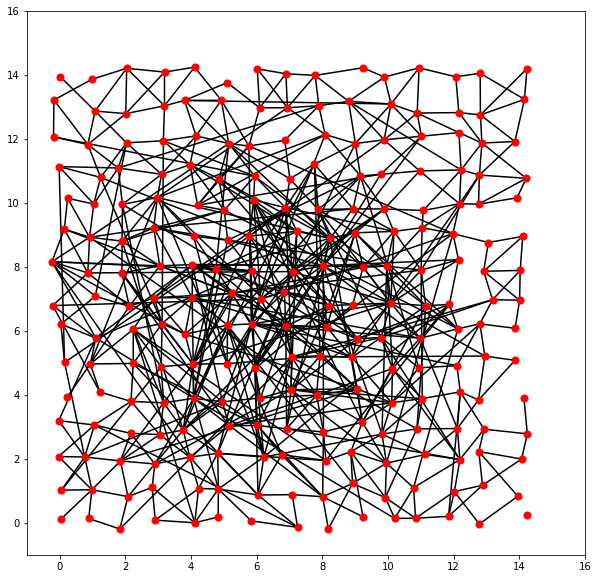

In [6]:
fig,ax = plt.subplots(1,1, figsize = (10,10))
ax.scatter(points[:,0], points[:,1], s= 50, c = 'r', zorder = 3)


def get_hyperellipsoid_from_homogeneous_matrix(Emat):
    An = (np.linalg.cholesky(Emat[:-1, :-1])).T
    center = np.linalg.solve(-Emat[:-1, :-1], Emat[-1, :-1])
    return Hyperellipsoid(An, center)

for i in range(len(points)-1):
    for j in range(i+1, len(points)):
        if ad_mat[i,j]:
            x = [points[i,0], points[j,0]]
            y = [points[i,1], points[j,1]]
            ax.plot(x,y, c = 'k')

#ax = plt.gca()
ax.set_xlim([-1,1+N*sp])
ax.set_ylim([-1,1+N*sp])
from ellipse_utils import plot_ellipse, get_homogeneous_matrix, arrange_homogeneous_ellipse_matrix_to_vector
from pydrake.all import Hyperellipsoid
# a = np.pi/3
# R = np.array([[np.cos(a), -np.sin(a)],[np.sin(a), np.cos(a)] ])
# A = R.T@np.array([[1.2,0], [0,1.2]])@R
clique, _, _ = max_clique(ad_mat)
print(f"maxclique { len(clique)}")
M = 0.5
N_tries = 1
import time
t1 = time.time()
for i in range(N_tries):
    clique2, Emat, v,  = max_clique_w_ellipsoidal_cvx_hull_constraint(ad_mat, points)
t2 = time.time()
print(f"ellipsoid clique size {len(clique2)}, avg time {(t2-t1)/N_tries}")


plot_ellipse_homogenous_rep(ax, Emat, xrange=[0, N*sp], yrange=[0, N*sp], resolution=0.1, linewidth=4, color = 'g', zorder =5)
# t1 = time.time()
# for i in range(N_tries):
#     clique3, _, _  = max_clique_w_cvx_hull_constraint(ad_mat, points)
# t2 = time.time()
# print(f"poly clique size {len(clique3)}, avg time {(t2-t1)/N_tries}")

ax.scatter(points[clique2, 0], points[clique2, 1], s = 500, c = 'c',zorder =10)
ax.scatter(points[clique, 0], points[clique, 1], s = 400, c = 'orange',zorder =11)

In [ ]:
Emat

array([[ 1.00000000e-06,  1.04706836e-06, -1.88411971e-05],
       [ 1.04706836e-06,  1.00000000e-06, -1.89559001e-05],
       [-1.88411971e-05, -1.89559001e-05,  1.00034861e+00]])

In [5]:
#CGSHOP example
from cgdataset import World
import matplotlib.pyplot as plt
import numpy as np
world = World('data/evalexamples/triangle.json')
offs = -0.06
world.build_offset_cfree(offs)
from seeding_utils import point_in_regions, point_near_regions, vis_reg, compute_kernels
from scipy.sparse import lil_matrix
from tqdm import tqdm
def sample_cfree_handle(n, m, regions=None):
    points = np.zeros((n,2))
    if regions is None: regions = []		
    for i in range(n):
        bt_tries = 0
        while bt_tries<m:
            point = world.sample_cfree_distance(1, offs)[0]
            #point = world.sample_cfree(1)[0]
            if point_near_regions(point, regions, tries = 100, eps = 0.1):
                bt_tries+=1
            else:
                break
        if bt_tries == m:
            return points, True
        
        points[i] = point
    return points, False

def vgraph_builder(points):
    n = len(points)
    adj_mat = lil_matrix((n,n))
    for i in tqdm(range(n)):
        point = points[i, :]
        for j in range(len(points[:i])):
            other = points[j]
            # if region_vis_obstacles:
            # 	if vis_reg(point, other, world, []):
            # 		adj_mat[i,j] = adj_mat[j,i] = 1
            # else:
            if  vis_reg(point, other, world, []):
                adj_mat[i,j] = adj_mat[j,i] = 1
    return adj_mat.toarray()

from scipy.spatial import ConvexHull
from pydrake.all import VPolytope

def seed_poly_hulls(cliques, pts):
    seed_polys = []
    for c in cliques:
        #print(c)
        if len(c)>= 3:
            pts_clique = pts[c,:]
            hull = ConvexHull(pts_clique)
            hull_vertices = pts_clique[hull.vertices, :]
            seed_polys.append(VPolytope(hull_vertices.T))
        else:
            seed_polys.append(None)
    return seed_polys

from utils import generate_maximally_different_colors
from seeding_utils import sorted_vertices

def plot_polys(seed_polys, cliques, pts, ax, colors):
    
    for idx, c in enumerate(cliques):
        colc = colors[idx]
        seed_pol = seed_polys[idx]
        scatter_plot = ax.scatter(pts[c, 0], pts[c, 1], s = 120*(len(cliques)-1.2*idx)/len(cliques), color = colc)
        #add edges from the center of each clique
        # for ci in c[1:]:
        #     ax.plot([pts[center,0], pts[ci,0]],[pts[center,1], pts[ci,1]], linewidth=1, c = colc)

        if seed_pol is not None:    
            v = sorted_vertices(seed_pol).T#s
            v = np.concatenate((v, v[0,:].reshape(1,-1)), axis=0)
            p = ax.plot(v[:,0], v[:,1], linewidth = 5, c = colc, zorder = 5)

            ax.fill(v[:,0], v[:,1], alpha = 0.2, c = p[0].get_color(), zorder = 5)
        else:
            ax.plot(pts[c, 0], pts[c, 1], linewidth = 5, c = colc)


#ax.set_xlim([-0,10.5])
#ax.set_ylim([-0,10.5])
counter_examples = []
for h in world.holes_tri:
    vol = h.MaximumVolumeInscribedEllipsoid().Volume()
    if vol > 1e-5:
        counter_examples.append(h.ChebyshevCenter())
counter_examples = np.array(counter_examples)
#ax.scatter(counter_examples[:,0], counter_examples[:,1], c = 'r', s = 400)
np.random.seed(25)
pts, _ = sample_cfree_handle(500, 3000, [])
# pts_lower = pts
# pts, _ = sample_cfree_handle(1, 3000, [])
#pts = pts[np.where(pts[:,1]>=5.5)[0], :]
# # pts, _ = sample_cfree_handle(5, 3000, [])
# # pts_upper = pts[np.where(pts[:,1]>=5.5)[0], :]
# #pts2 = pts[[0,2,4,5,7,8], :]
# cluster = np.array([[3.3,9.3], [0.99,6.6], [8.45,7.4], [5,6],[6,6],[9,2.5]])
# pc = []
# for c in cluster:
#     for idx in range(2):
#         pc+=[0.4*(np.random.rand(2)-0.5) +c]
# pc = np.array(pc)
# pts = pc# np.concatenate((pts_lower,pts_lower2,pc), axis = 0)
# #pts = np.delete(pts, [14,19], axis = 0)
ad_mat = vgraph_builder(pts)


/home/peter/.local/lib/python3.8/site-packages/scipy/__init__.py:143: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.17.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
100%|██████████| 500/500 [00:32<00:00, 15.59it/s]


In [9]:
from clique_covers import compute_greedy_clique_cover_w_ellipsoidal_convex_hull_constraint, compute_greedy_clique_partition

True
True
True
True


In [15]:
import time

True
True
True
True


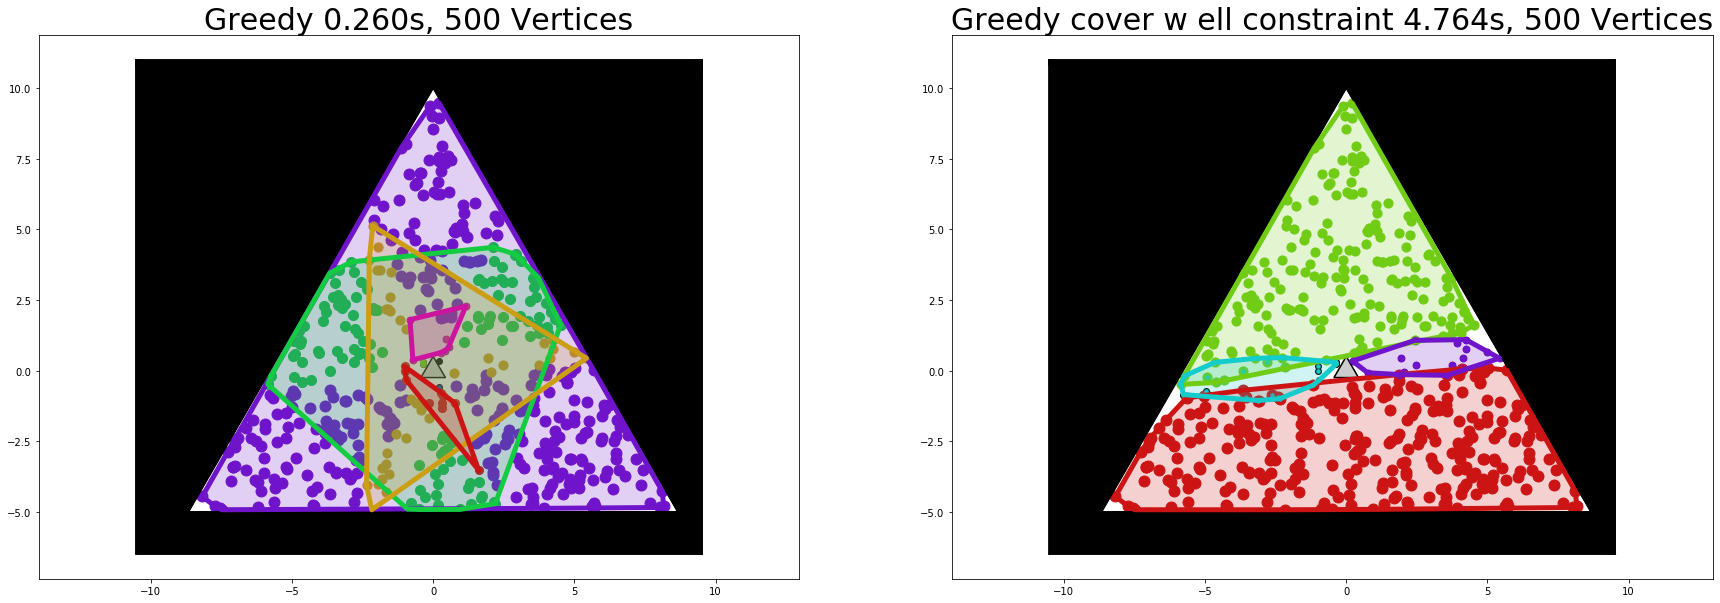

In [21]:
fig, axs= plt.subplots(1,2,  figsize = (30,10))
t1 = time.time()
cliques_e = compute_greedy_clique_cover_w_ellipsoidal_convex_hull_constraint(ad_mat, pts, max_eig = 0.005)
t2 = time.time()
t_e = t2-t1
t1 = time.time()
cliques = compute_greedy_clique_partition(ad_mat)
t2 = time.time()
t_normal = t2-t1
names = [f"Greedy {t_normal:.3f}s, {len(pts)} Vertices", f"Greedy cover w ell constraint {t_e:.3f}s, {len(pts)} Vertices"]
for ax, c, n in zip(axs, [cliques, cliques_e], names):
    colors = generate_maximally_different_colors(len(c))
    world.plot_cfree_skel(ax)
    ax.scatter(pts[:, 0], pts[:, 1], c = 'k')
    ax.axis('equal')
    ax.set_title(n, fontsize = 30)
    seed_polys = seed_poly_hulls(c, pts)
    plot_polys(seed_polys, c, pts, ax, colors)

In [17]:
c

True
True
7.414883732795715
285
True
True
5.840137004852295
285
True
True
3.396848440170288
284
True
True
2.743372917175293
283


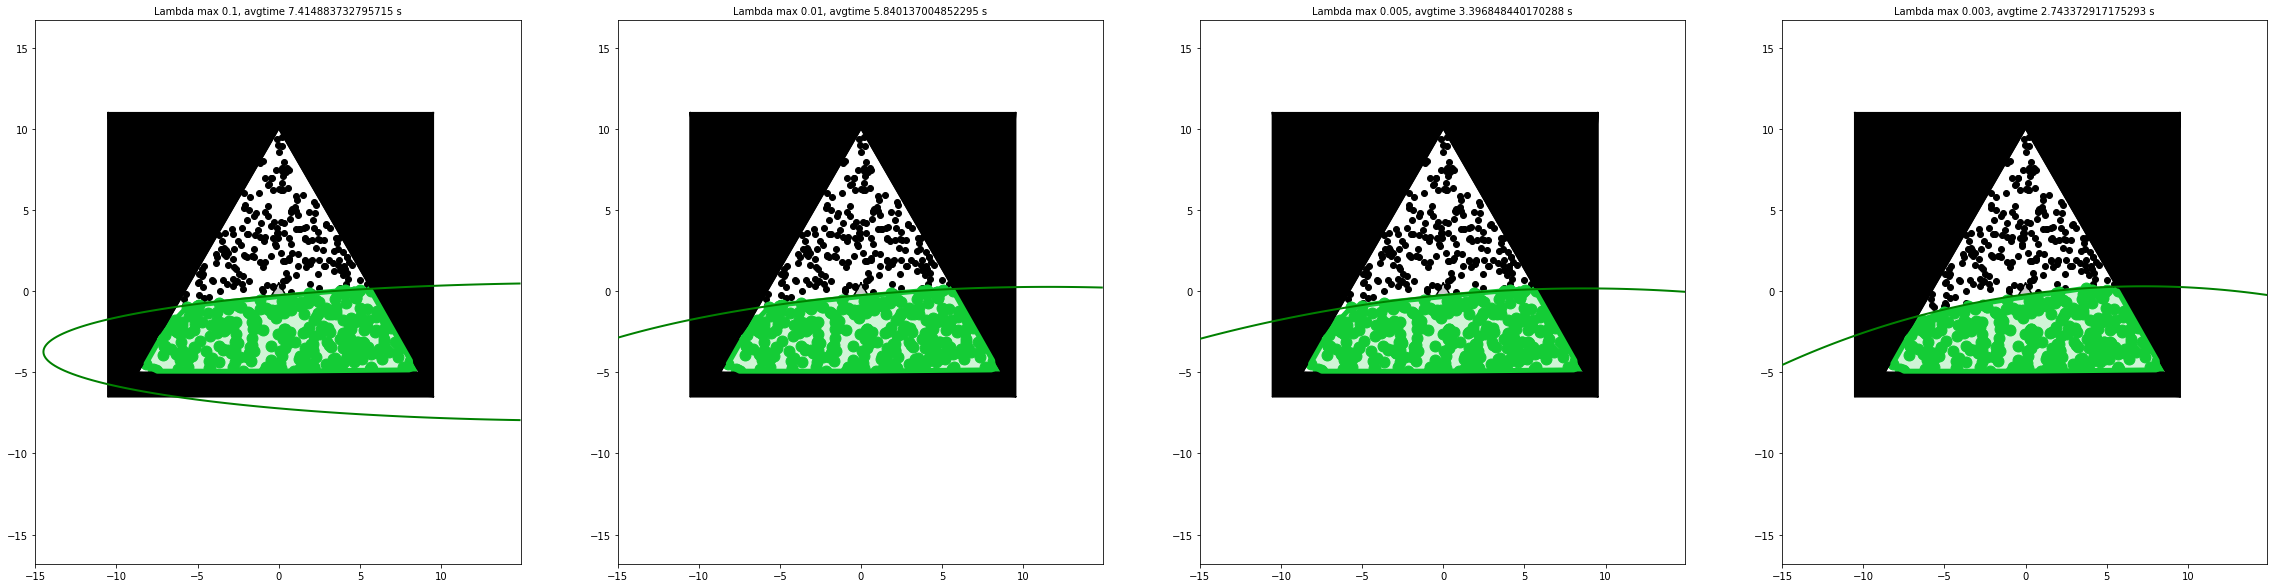

In [48]:

N_tries = 2
# t1 = time.time()
Max_eigs = [0.1, 0.01, 0.005, 0.003]
fig, axs = plt.subplots(1,len(Max_eigs),  figsize = (40,10))
colors = [(0.07999999999999999, 0.8, 0.21090909090909077)]
Mvals_ = []
for m_e, ax in zip(Max_eigs, axs):
    t1 = time.time()
    for _ in range(N_tries):
        clique_ell, Emat, b, M_vals = max_clique_w_ellipsoidal_cvx_hull_constraint(ad_mat, pts, min_eig=1e-3, max_eig=m_e, r_scale=1.0 )#max_clique_w_cvx_hull_constraint(ad_mat, pts)
    t2 = time.time()
    print(f"{(t2-t1)/N_tries}")
    Mvals_.append(M_vals)
    print(len(clique_ell))
    world.plot_cfree_skel(ax)
    ax.scatter(pts[:, 0], pts[:, 1], c = 'k')
    ax.axis('equal')
    ax.set_title(f"Lambda max {m_e}, avgtime {(t2-t1)/N_tries} s", fontsize = 10)
    seed_polys = seed_poly_hulls([clique_ell], pts)
    plot_polys(seed_polys, [clique_ell], pts, ax, colors)
    plot_ellipse_homogenous_rep(ax,Emat,xrange=[-15, 15], yrange=[-15, 15], resolution=0.1, linewidth=2, color = 'g',zorder =10 )
# clique_no_hyp, w, b = max_clique(ad_mat)
# print(len(clique_no_hyp))
# print(len(clique_hyp))
# #cliques, w, b, h, result, lambdas = min_clique_cover_sep(ad_mat, pts, counter_examples)
# colors = [(0.07999999999999999, 0.8, 0.21090909090909077)]#generate_maximally_different_colors(2+20)[20:]#[generate_maximally_different_colors(len(cliques)+10)[i] for i in [0,5,7,4]]
# seed_polys = seed_poly_hulls([clique_no_hyp], pts)


# for i in range(pts.shape[0]-1):
#     for j in range(i+1, pts.shape[0]):
#         if ad_mat[i,j] ==1:
#             plt.plot(pts[[i,j], 0], pts[[i,j], 1], c = 'k', alpha = 0.1, linewidth = 1, zorder = 0)
# plot_polys(seed_polys, [clique_no_hyp], pts, ax, [(0.8,0,0)])

#plt.savefig('triangle_max_clique_no_hyp.pdf')
# fig, ax = plt.subplots(1,1, figsize = (12,10))
# world.plot_cfree_skel(ax)
# ax.scatter(pts[:, 0], pts[:, 1], c = 'k')
# # for i in range(pts.shape[0]-1):
# #     for j in range(i+1, pts.shape[0]):
# #         if ad_mat[i,j] ==1:
# #             plt.plot(pts[[i,j], 0], pts[[i,j], 1], c = 'k', alpha = 0.1, linewidth = 1, zorder = 0)
# seed_polys = seed_poly_hulls([clique_hyp], pts)
# print(Emat)


# #plt.savefig('triangle_max_clique_hyp.pdf')
# ax.axis('equal')


In [37]:
M_vals

array([0.78573296, 0.24145438, 0.52777741, 0.36552707, 0.66051896,
       0.7734916 , 0.52859165, 0.49562106, 0.65272737, 0.88817047,
       1.04005199, 1.51716273, 0.63552682, 0.74536948, 0.85627218,
       1.17412741, 0.97440671, 0.82944509, 0.99365849, 0.32068633,
       0.64409412, 0.81442543, 1.21651914, 0.66237415, 0.5712582 ,
       0.48826266, 0.88744557, 0.75243479, 1.17302342, 1.31798154,
       0.25752236, 1.53580215, 0.98943627, 1.04866667, 1.0181993 ,
       0.75130085, 0.28825796, 1.23235705, 1.11341184, 0.52286129,
       0.55354529, 1.03313102, 0.57095302, 1.06224622, 0.571013  ,
       0.8284878 , 0.55717749, 0.6221678 , 0.88886618, 0.82933433,
       1.05223415, 0.60730786, 1.51901657, 0.94380526, 0.7430141 ,
       1.03920112, 0.8650742 , 0.29016524, 0.78723583, 0.83274326,
       0.64677044, 0.86499176, 0.97769274, 0.58732029, 0.91393261,
       0.64678429, 0.63157018, 0.73743771, 0.78264511, 0.41862748,
       0.96579678, 0.65448455, 0.7033652 , 0.64629941, 1.31927

In [22]:
HS = compute_outer_LJ_sphere(points)

In [20]:
1/np.linalg.eig(HS.A())[0]

array([10.54872322, 10.54872322])

In [23]:
radius = 1/(HS.A()[0,0]+1e-6)
center = HS.center()
dists = np.linalg.norm((points-center.reshape(1,-1)), axis=1)

In [26]:
(dists+radius)**2

array([422.54950599, 396.55816227, 373.8383379 , 350.83401596,
       329.69716984, 318.7055281 , 313.48771106, 320.4319099 ,
       323.49763987, 317.79092825, 326.17140481, 350.88545449,
       374.98906076, 401.82542217, 415.89208058, 397.77671091,
       369.65402052, 349.92332335, 319.48810509, 295.94974218,
       293.16477867, 280.00478959, 275.36828544, 284.14079642,
       289.61295652, 297.91540835, 305.21958337, 337.56042975,
       356.32277377, 386.20848735, 384.56233383, 347.89026123,
       323.08790643, 294.35648534, 273.50589767, 252.79205804,
       242.16870131, 242.50084865, 250.47787905, 257.09710951,
       271.33927619, 295.50477392, 306.20635581, 329.95658511,
       370.62008324, 352.83150858, 323.1567153 , 300.78962968,
       273.89350999, 248.80009667, 230.51828854, 215.05737077,
       219.17175522, 216.82524714, 233.8284146 , 245.97591816,
       257.52948096, 281.32782137, 310.79727313, 343.29513468,
       335.38426678, 298.89479819, 274.03670509, 255.23

In [107]:
np.where(np.abs(b)-1<=1e-4)[0]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [110]:
idx_non_clique = np.delete(np.arange(len(pts)), clique_hyp)

pts_non_clique = pts[idx_non_clique, :]
fq = build_quadratic_features(pts_non_clique)
hE = arrange_homogeneous_ellipse_matrix_to_vector(Emat)


In [111]:
b[idx_non_clique]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [89]:
ellipse_dist = (hE@fq.T).T
violators = np.where(ellipse_dist<=1)[0]
print(ellipse_dist[violators])
print(b[idx_non_clique[violators]])

[0.81986625 0.16683502 0.10188344 0.45016795 0.27882736 0.14587934
 0.25993563]
[1. 1. 1. 1. 1. 1. 1.]


In [92]:
idx_non_clique[violators]

array([ 31,  42, 123, 161, 195, 326, 436])

In [95]:
len(clique_hyp)

280

In [36]:
N_tries = 1
M = 10
t1 = time.time()
for _ in range(N_tries):
    clique_hyp, Emat, b = max_clique_w_ellipsoidal_cvx_hull_constraint(ad_mat, pts, M=M)
t2 = time.time()

print(f"avg_runtime {(t2-t1)/N_tries}")
len(clique_hyp)
print(Emat)

True
avg_runtime 3.4761645793914795
[[ 1.00000000e-03  0.00000000e+00 -1.89911056e-02]
 [ 0.00000000e+00  6.11134202e-02  2.32396003e-01]
 [-1.89911056e-02  2.32396003e-01  1.11245163e+00]]


In [37]:
N_tries = 1
M = 1
t1 = time.time()
for _ in range(N_tries):
    clique_hyp, Emat, b = max_clique_w_ellipsoidal_cvx_hull_constraint(ad_mat, pts, M=M)
t2 = time.time()

print(f"avg_runtime {(t2-t1)/N_tries}")
len(clique_hyp)
print(Emat)

True
avg_runtime 2.149533748626709
[[ 1.00000000e-03  0.00000000e+00 -7.15290496e-03]
 [ 0.00000000e+00  1.00000000e-03  4.69959774e-02]
 [-7.15290496e-03  4.69959774e-02  1.02222755e+00]]


(-100, 100)

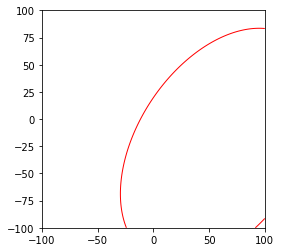

In [74]:
Emat = np.array([[0.3,-0.1,-20.1],
                 [-0.1,0.2,10.8],
                 [-20.1,10.8,-500.01]])
r = 100
fig, ax = plt.subplots(figsize = (4,4))
plot_ellipse_homogenous_rep(ax, Emat, xrange=[-r,r], yrange=[-r,r],resolution= 0.1, color='r')
ax.set_xlim([-r,r])
ax.set_ylim([-r,r])

In [38]:
N_tries = 1
M = 0.1
t1 = time.time()
for _ in range(N_tries):
    clique_hyp, Emat, b = max_clique_w_ellipsoidal_cvx_hull_constraint(ad_mat, pts, M=M)
t2 = time.time()

print(f"avg_runtime {(t2-t1)/N_tries}")
len(clique_hyp)
print(Emat)

True
avg_runtime 6.271590948104858
[[ 1.00000000e-03  0.00000000e+00 -1.12013041e-03]
 [ 0.00000000e+00  1.00000000e-03  5.60612454e-04]
 [-1.12013041e-03  5.60612454e-04  9.99960716e-01]]


In [35]:
Emat

array([[ 1.00000000e-03,  0.00000000e+00, -1.12013041e-03],
       [ 0.00000000e+00,  1.00000000e-03,  5.60612454e-04],
       [-1.12013041e-03,  5.60612454e-04,  9.99960716e-01]])

In [40]:
build_quadratic_features(np.array([[2,3,1],
                                   [2,3,1],
                                   [2,3,1],
                                    ]))

array([[4., 9., 1., 1., 6., 2., 2., 3., 3., 1.],
       [4., 9., 1., 1., 6., 2., 2., 3., 3., 1.],
       [4., 9., 1., 1., 6., 2., 2., 3., 3., 1.]])

In [18]:
colors = generate_maximally_different_colors(2+20)[20:]
colors

[(0.07999999999999999, 0.8, 0.21090909090909077),
 (0.8, 0.07999999999999999, 0.6690909090909093)]

[ 0  3  4  5  7  9 10 11 12 13 15 16 18 20 21 22 23 26 27 28 29 31 32 33
 34 35 37 38 39 40 41 43 47 48 50 52 53 54 55 59 60 61 62 64 66 68 70 71
 74 75 76 77 78 79 80 81 84 85 90 93 94 98 99]
[ 0  3  4  6  9 10 11 13 14 15 16 17 18 21 23 25 27 28 31 33 36 38 39 40
 41 42 43 45 51 52 53 58 60 61 64 65 66 68 70 71 74 75 76 77 78 79 80 85
 86 91 92 93 94 96 97 99]
63
56


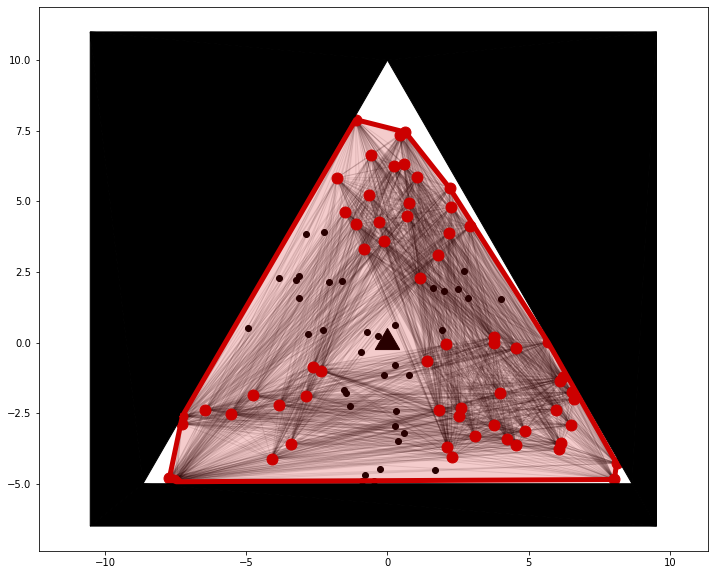

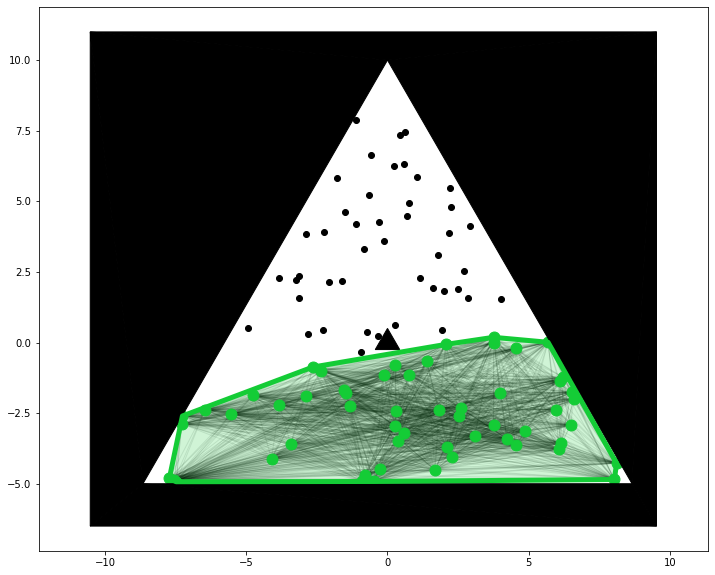

In [19]:
fig, ax = plt.subplots(1,1, figsize = (12,10))
world.plot_cfree(ax)
for i in range(pts.shape[0]-1):
    for j in range(i+1, pts.shape[0]):
        if i in clique_no_hyp and j in clique_no_hyp and ad_mat[i,j] ==1:
            plt.plot(pts[[i,j], 0], pts[[i,j], 1], c = 'k', alpha = 0.1, linewidth = 1, zorder = 0)
ax.scatter(pts[:, 0], pts[:, 1], c = 'k')

seed_polys = seed_poly_hulls([clique_no_hyp], pts)
plot_polys(seed_polys, [clique_no_hyp], pts, ax, [(0.8,0,0)])
ax.axis('equal')
plt.savefig('triangle_max_clique_no_hyp.pdf')
fig, ax = plt.subplots(1,1, figsize = (12,10))
world.plot_cfree(ax)
ax.scatter(pts[:, 0], pts[:, 1], c = 'k')
for i in range(pts.shape[0]-1):
    for j in range(i+1, pts.shape[0]):
        if i in clique_hyp and j in clique_hyp and ad_mat[i,j] ==1:
            plt.plot(pts[[i,j], 0], pts[[i,j], 1], c = 'k', alpha = 0.1, linewidth = 1, zorder = 0)
seed_polys = seed_poly_hulls([clique_hyp], pts)
plot_polys(seed_polys, [clique_hyp], pts, ax, colors)
plt.savefig('triangle_max_clique_hyp.pdf')
ax.axis('equal')
print(len(clique_no_hyp))
print(len(clique_hyp))

In [38]:
idxs2 = idxs[np.where(pts[idxs,0]<=4)[0]]
idxs2

array([ 0,  1, 10, 14, 21, 25, 28, 38, 39, 47, 50, 80, 83, 90, 94])

In [40]:
idxs3 = idxs[np.where(pts[idxs2,0]>=3.7)[0]]
idxs3

array([39])

average time = 8.30 over 10 tries, with 50 points excluded, on a graph of size 400
success
binary assignment:  [-0. -0. -0.  0. -0. -0. -0.  0. -0. -0. -0. -0.  0.  1. -0.  1. -0. -0.
 -0. -0. -0. -0. -0.  1. -0. -0. -0.  1. -0. -0. -0. -0. -0.  0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0. -0. -0. -0.
 -0.  0. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0.
 -0. -0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0.  0. -0. -0.  0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0.  0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. 

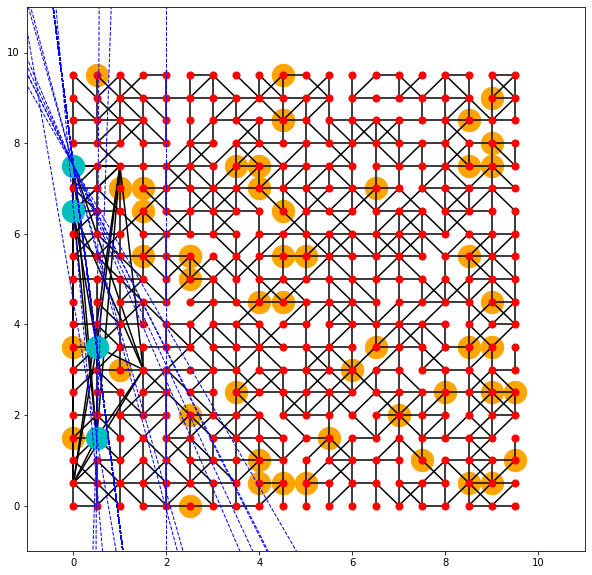

In [243]:
N = 20
sp = 0.5
np.random.seed(0)
points  = []
for i in range(N):
    for j in range(N):
        points.append(np.array([i*sp,j*sp]))
points = np.array(points)
ad_mat = np.zeros((N*N,N*N))
for i in range(N-1):
    for j in range(N-1):
        i1 = i + j*N
        i2 = i+1+ j*N
        i3 = i+1 +(j+1)*N
        i4 = i +(j+1)*N
        edges = np.where(np.random.rand(6)>0.5)[0]
        for e in edges:
            if e==0:
                ad_mat[i1,i2] =1
                ad_mat[i2,i1] =1
            if e==1:
                ad_mat[i2,i3] =1
                ad_mat[i3,i2] =1
            if e==2:
                ad_mat[i3,i4] =1
                ad_mat[i4,i3] =1
            if e==3:
                ad_mat[i4,i1] =1
                ad_mat[i1,i4] =1
            if e==4:
                ad_mat[i1,i3] =1
                ad_mat[i3,i1] =1
            if e==5:
                ad_mat[i2,i4] =1
                ad_mat[i4,i2] =1

# ad_mat[1,-1] = 1
# ad_mat[-1,1] = 1
# ad_mat[1,-2] = 1
# ad_mat[-2,1] = 1
# ad_mat[1,-3] = 1
# ad_mat[-3,1] = 1
# ad_mat[1,-4] = 1
# ad_mat[-4,1] = 1

# ad_mat[2,-1] = 1
# ad_mat[-1,2] = 1
# ad_mat[2,-2] = 1
# ad_mat[-2,2] = 1
# ad_mat[2,-3] = 1
# ad_mat[-3,2] = 1
# ad_mat[2,-4] = 1
# ad_mat[-4,2] = 1
clique = [1, 13, 23, 15, 27, 55, 66]
for i,c in enumerate(clique[:-1]):
    for c2 in clique[i+1:]:
        ad_mat[c,c2] = 1
        ad_mat[c2,c] = 1

fig,ax = plt.subplots(1,1, figsize = (10,10))
ax.scatter(points[:,0], points[:,1], s= 50, c = 'r', zorder = 3)


for i in range(len(points)-1):
    for j in range(i+1, len(points)):
        if ad_mat[i,j]:
            x = [points[i,0], points[j,0]]
            y = [points[i,1], points[j,1]]
            ax.plot(x,y, c = 'k')

#ax = plt.gca()
ax.set_xlim([-1,1+N*sp])
ax.set_ylim([-1,1+N*sp])
#ax.axis('equal')
#excl =99
excl = 50
points_to_exclude =  points[np.random.choice(N**2,excl), :]

import time
tries = 10
t1 = time.time()
for _ in range(tries):
    success, v, lambdas, gammas = max_clique_w_exclusion_points(ad_mat, points, points_to_exclude)
t2 = time.time()
print(f"average time = {(t2-t1)/tries:.2f} over {tries} tries, with {excl} points excluded, on a graph of size {N**2}")

ax.scatter(points_to_exclude[:, 0], points_to_exclude[:,1], c = 'orange', s = 500, zorder =1)
#lambdas = lambdas.squeeze()

print(f"{'success' if success else 'optimzation failed'}")
print('binary assignment: ', v)
print('lambda critical: ', lambdas)
#print('gamma critical: ', gammas)
pts_idx = np.where(np.abs(v)>=1e-4)[0]
clique = np.array([points[i] for i in pts_idx])
ax.scatter(clique[:, 0], clique[:, 1], c = 'c', s = 500, zorder = 10)

for i in range(lambdas.shape[0]):
    lamb = lambdas[i,:]
    hpts = hyperplanepoints(lamb)#np.clip(hyperplanepoints(lamb), -1, (N)*sp)
    ax.plot(hpts[:,0], hpts[:,1], linewidth = 1, linestyle = '--', c= 'b', zorder = 20)

In [239]:
from independent_set_solver import solve_max_independent_set_integer

tries = 10
t1 = time.time()
for _ in range(tries):
    adj_curr = ad_mat.copy()
    adj_curr = 1- adj_curr
    np.fill_diagonal(adj_curr, 0)
    val = solve_max_independent_set_integer(adj_curr)
t2 = time.time()
print(f"average time = {(t2-t1)/tries} over {tries} tries, with {0} points excluded, on a graph of size {N**2}")

average time = 0.09878907203674317 over 10 tries, with 0 points excluded, on a graph of size 100


In [234]:
val

(7.0, (array([ 1, 13, 15, 23, 27, 55, 66]),))

In [99]:
A = np.array([lamb_sol[0], lamb_sol[1]]).reshape(1,2)
b = np.array([lamb_sol[2]])
np.linalg.solve(A.T@A,A.T@b.reshape(1,1))

LinAlgError: Singular matrix

In [98]:
A.T@b.reshape(1,1)

array([[-2.],
       [ 0.]])

In [96]:
A.shape

(2, 1)

In [41]:
np.ones((1,n))@gammas[i,:]

array([<Expression "(x(4,0) + x(4,1) + x(4,2) + x(4,3) + x(4,4))">],
      dtype=object)

In [28]:
np.matmul(Points_mat,lambdas[i,:])

array([<Expression "x(0,2)">, <Expression "(x(0,0) + x(0,2))">,
       <Expression "(x(0,0) + x(0,1) + x(0,2))">,
       <Expression "(x(0,1) + x(0,2))">,
       <Expression "(2 * x(0,0) + 0.5 * x(0,1) + x(0,2))">], dtype=object)